# Numerical validation - Cohen's d

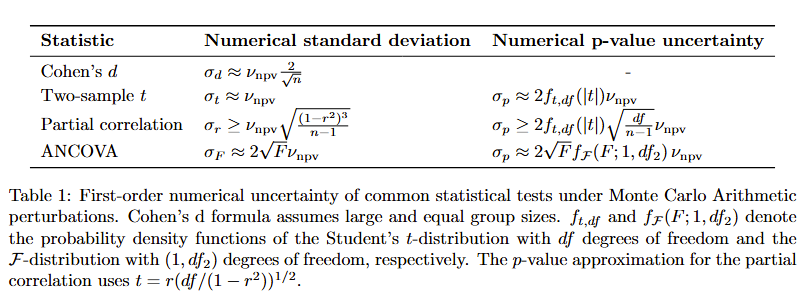

In [1]:
from IPython.display import Image
import pandas as pd
from pathlib import Path
import plotly.express as px
import numpy as np
import scipy.stats
from typing import Tuple, Union

anonymizer = True

root_dir = Path.cwd()


def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Root directory: {anondir(root_dir)}")
input_dir = root_dir / "navr" / "csv_all"
print(f"Input dir: {anondir(input_dir)}")
stats_dir = root_dir / "cohen_d"
print(f"Stats dir: {anondir(stats_dir)}")
output_dir = root_dir / "numerical_validation"
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output dir: {anondir(output_dir)}")
figures_dir = output_dir / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)
print(f"Figures dir: {anondir(figures_dir)}")
csv_dir = output_dir / "csv"
csv_dir.mkdir(parents=True, exist_ok=True)
print(f"CSV dir: {anondir(csv_dir)}")

Root directory: <living-park>
Input dir: <living-park>/navr/csv_all
Stats dir: <living-park>/cohen_d
Output dir: <living-park>/numerical_validation
Figures dir: <living-park>/numerical_validation/figures
CSV dir: <living-park>/numerical_validation/csv


In [2]:
subcortical_regions = [
    "Left-Thalamus",
    "Left-Caudate",
    "Left-Putamen",
    "Left-Pallidum",
    "Left-Hippocampus",
    "Left-Amygdala",
    "Left-Accumbens-area",
    "Right-Thalamus",
    "Right-Caudate",
    "Right-Putamen",
    "Right-Pallidum",
    "Right-Hippocampus",
    "Right-Amygdala",
    "Right-Accumbens-area",
]

# Cortical regions in DKT atlas
cortical_regions = [
    "bankssts",
    "caudalanteriorcingulate",
    "caudalmiddlefrontal",
    "cuneus",
    "entorhinal",
    "fusiform",
    "inferiorparietal",
    "inferiortemporal",
    "isthmuscingulate",
    "lateraloccipital",
    "lateralorbitofrontal",
    "lingual",
    "medialorbitofrontal",
    "middletemporal",
    "parahippocampal",
    "paracentral",
    "parsopercularis",
    "parsorbitalis",
    "parstriangularis",
    "pericalcarine",
    "postcentral",
    "posteriorcingulate",
    "precentral",
    "precuneus",
    "rostralanteriorcingulate",
    "rostralmiddlefrontal",
    "superiorfrontal",
    "superiorparietal",
    "superiortemporal",
    "supramarginal",
    "frontalpole",
    "temporalpole",
    "transversetemporal",
    "insula",
]

In [3]:
metrics = ["area", "thickness", "volume", "subcortical_volume"]
studies = ["cross-sectional", "longitudinal"]
timepoints = ["baseline", "followup"]
groups = ["HC", "PD", "HC-PD"]


def is_cortical(metric):
    if metric not in metrics:
        raise ValueError(f"{metric} not in {metrics}")
    return metric != "subcortical_volume"


def _assert_args(metric, study, group, timepoint):
    if metric not in metrics:
        raise ValueError(f"{metric} not in {metrics}")
    if study not in studies:
        raise ValueError(f"{study} not in {studies}")
    if group not in groups:
        raise ValueError(f"{group} not in {groups}")
    if timepoint is not None and timepoint not in timepoints:
        raise ValueError(f"{timepoint} not in {timepoints}")


def get_navr_csv(input_dir, metric, study, group, timepoint=None):
    _assert_args(metric, study, group, timepoint)
    _study = study
    _timepoint = timepoint
    group = group.lower()
    if study == "cross-sectional":
        if timepoint is None:
            raise ValueError("Missing timepoint for cross-sectional")
        study = ""
        timepoint = f"_{timepoint}_"
    elif study == "longitudinal":
        study = "_" + study
        timepoint = "_"
    filename = input_dir / f"navr_{group}{timepoint}{metric}{study}.csv"
    df = pd.read_csv(filename)
    df["group"] = group.upper()
    df["study"] = _study
    df["timepoint"] = _timepoint
    return df

In [4]:
def load_navr_data(input_dir: Path, metric: str) -> pd.DataFrame:
    """Load all NAVR data into a single DataFrame."""
    df_all = pd.DataFrame()
    for study in studies:
        for group in groups:
            for timepoint in timepoints:
                if study == "longitudinal":
                    timepoint = None
                df = get_navr_csv(input_dir, metric, study, group, timepoint)
                df_all = pd.concat([df_all, df], ignore_index=True)
    df_all["metric"] = metric
    return df_all

## Statistics uncertainty

In [5]:
def var_d(n, navr):
    return (4 / n) * navr**2


def std_d(n, navr):
    var = var_d(n, navr)
    return np.sqrt(var)


# No p-value for Cohen's d
def std_p():
    return np.nan

### Code

In [6]:
STATISTICS_TO_COMPUTE = ["mean", "std", "min", "max", "median"]
NUM_PARAMETERS = 4  # Typically: intercept + diagnosis + age + sex


def _ensure_valid_stat_functions(stat_functions):
    required_keys = ["metric", "stat_name", "std_statistic", "std_pvalue"]
    for key in required_keys:
        if key not in stat_functions:
            raise ValueError(f"stat_functions must contain key '{key}'")


def prepare_data(
    data_path: Path, nu_nav: pd.DataFrame, hemisphere: bool, stat: str
) -> Tuple[pd.DataFrame, pd.DataFrame, int]:
    """
    Load and prepare results with region metadata.

    Parameters
    ----------
    data_path : Path
        Path to results parquet file
    nu_nav : pd.DataFrame
        Navigation dataframe with region metadata

    Returns
    -------
    df : pd.DataFrame
        Raw results
    stats : pd.DataFrame
        Summary statistics by region
    sample_size : int
        Number of subjects in analysis
    """
    # Load results
    df = pd.read_parquet(data_path)
    df = df.rename(columns={"p-unc": "p-val"})

    # Calculate summary statistics
    groupby_cols = ["region", "hemisphere"] if hemisphere else ["region"]
    stats = (
        df.groupby(groupby_cols)
        .agg({stat: STATISTICS_TO_COMPUTE, "n": "first"})
        .reset_index()
    )

    # Flatten column names
    stats.columns = ["_".join(col).strip("_") for col in stats.columns.values]

    # Add region metadata
    on = ["region", "hemisphere"] if hemisphere else ["region"]
    stats = pd.merge(stats, nu_nav, on=on, how="left")

    # Extract sample size
    sample_size = int(df["n"].iloc[0])

    return df, stats, sample_size


def calculate_theoretical_distributions(
    stats: pd.DataFrame,
    stat_functions,
    sample_size: int,
    num_params: int = NUM_PARAMETERS,
) -> pd.DataFrame:
    """
    Add theoretical distribution parameters to stats dataframe.

    Parameters
    ----------
    stats : pd.DataFrame
        Summary statistics dataframe
    stat_functions : function
        Functions to compute theoretical statistics
    sample_size : int
        Number of subjects
    num_params : int
        Number of parameters in model

    Returns
    -------
    pd.DataFrame
        Stats with theoretical distributions added
    """
    stats = stats.copy()

    # Add sample size
    stats["n"] = sample_size
    stats["df_denominator"] = sample_size - num_params

    # F-statistic theoretical values
    stat_name = stat_functions["stat_name"]
    F, F_ci_low, F_ci_high = stat_functions["std_statistic"](stats)
    stats[f"{stat_name}_std_theoretical"] = F
    stats[f"{stat_name}_std_theoretical_low"] = F_ci_low
    stats[f"{stat_name}_std_theoretical_high"] = F_ci_high

    return stats


def calculate_empirical_vs_theoretical_differences(
    stats: pd.DataFrame, stat_functions
) -> pd.DataFrame:
    """
    Calculate differences between empirical and theoretical distributions.

    Parameters
    ----------
    stats : pd.DataFrame
        Stats with both empirical and theoretical values
    stat_name : str
        Name of the statistic to compute differences for
    stat_functions : function
        Functions to compute theoretical statistics

    Returns
    -------
    pd.DataFrame
        Stats with difference metrics added
    """
    stats = stats.copy()
    display(stats.head())
    # statistic differences
    stat_name = stat_functions["stat_name"]
    stats[f"{stat_name}_std_diff"] = np.abs(
        stats[f"{stat_name}_std"] - stats[f"{stat_name}_std_theoretical"]
    )
    stats[f"{stat_name}_std_diff_rel"] = stats[f"{stat_name}_std_diff"] / stats[
        f"{stat_name}_std_theoretical"
    ].replace(0, np.nan)

    return stats


def get_test_stats(
    data_path: Path, stat_functions, nu_nav: pd.DataFrame, hemisphere: bool, study: str
):
    """
    Perform statistical analysis of ANCOVA results for cortical thickness.

    Parameters
    ----------
    data_path : Path
        Path to the ANCOVA results file
    stat_functions : function
        Functions to compute theoretical statistics
    nu_nav : pd.DataFrame
        DataFrame containing region metadata
    hemisphere : bool
        Whether to consider hemispheres separately

    Returns
    -------
    None
    """
    _ensure_valid_stat_functions(stat_functions)
    stat_name = stat_functions["stat_name"]
    metric = stat_functions["metric"]

    # Load and prepare data
    df, stats, sample_size = prepare_data(
        data_path, nu_nav=nu_nav, hemisphere=hemisphere, stat=stat_name
    )
    filename = csv_dir / study / metric / f"cohen_d_stats_{stat_name}.csv"
    filename.parent.mkdir(parents=True, exist_ok=True)
    stats.to_csv(filename, index=False)
    print(f"Saved Cohen's d stats to: {anondir(filename)}")

    # Calculate theoretical distributions
    stats = calculate_theoretical_distributions(stats, stat_functions, sample_size)
    filename = csv_dir / study / metric / f"theoretical_distributions_{stat_name}.csv"
    filename.parent.mkdir(parents=True, exist_ok=True)
    stats.to_csv(filename, index=False)
    print(f"Saved theoretical distributions to: {anondir(filename)}")

    # Calculate differences
    stats = calculate_empirical_vs_theoretical_differences(stats, stat_functions)
    filename = (
        csv_dir
        / study
        / metric
        / f"empirical_vs_theoretical_differences_{stat_name}.csv"
    )
    filename.parent.mkdir(parents=True, exist_ok=True)
    stats.to_csv(filename, index=False)
    print(f"Saved empirical vs theoretical differences to: {anondir(filename)}")

    print("=" * 60)
    print("Cohen's d Theoretical vs Empirical Distribution Analysis")
    print("=" * 60)
    print(f"Sample size: {sample_size}")
    print(f"Degrees of freedom: {sample_size - NUM_PARAMETERS}")
    print(f"Number of regions: {len(stats)}")
    print("\nEmpirical vs Theoretical Comparison:")
    print(
        f"  Mean Cohen's d std relative diff: {stats[f'{stat_name}_std_diff_rel'].mean():.3%}"
    )
    print("=" * 60)

    display(stats.head())

    return df, stats

In [7]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# Map hemispheres to symbols
hemisphere_symbols = {
    "lh": "triangle-left",
    "rh": "triangle-right",
}


def create_dual_axis_plot(stats: pd.DataFrame, stat_name: str) -> go.Figure:
    """
    Create dual-axis plot showing F-score mean and standard deviation.

    Parameters
    ----------
    stats : pd.DataFrame
        Statistics dataframe with F-score metrics

    Returns
    -------
    go.Figure
        Plotly figure object
    """
    fig = go.Figure()

    # Color scheme
    colors = {"mean": "#1f77b4", "empirical": "#ff7f0e", "theoretical": "#2ca02c"}

    # Mean F-scores (left y-axis)
    fig.add_trace(
        go.Scatter(
            x=stats["region"],
            y=stats[f"{stat_name}_mean"],
            name=f"{stat_name} Mean",
            yaxis="y1",
            mode="markers",
            marker=dict(size=8, color=colors["mean"], opacity=0.7),
            hovertemplate="<b>%{x}</b><br>"
            + f"Mean {stat_name}: %{{y:.2f}}<br>"
            + "<extra></extra>",
        )
    )

    # Empirical standard deviation (right y-axis, log scale)
    fig.add_trace(
        go.Scatter(
            x=stats["region"],
            y=stats[f"{stat_name}_std"],
            name="Empirical Std",
            yaxis="y2",
            mode="markers",
            marker=dict(
                size=8, color=colors["empirical"], opacity=0.7, symbol="circle"
            ),
            hovertemplate="<b>%{x}</b><br>"
            + "Empirical Std: %{y:.3f}<br>"
            + "<extra></extra>",
        )
    )

    # Theoretical standard deviation with error bars (right y-axis)
    fig.add_trace(
        go.Scatter(
            x=stats["region"],
            y=stats[f"{stat_name}_std_theoretical"],
            error_y=dict(
                type="data",
                array=(
                    stats[f"{stat_name}_std_theoretical_high"]
                    - stats[f"{stat_name}_std_theoretical"]
                ).values,
                arrayminus=(
                    stats[f"{stat_name}_std_theoretical"]
                    - stats[f"{stat_name}_std_theoretical_low"]
                ).values,
                visible=True,
                thickness=1,
                width=2,
                color=colors["theoretical"],
            ),
            name="Theoretical Std",
            yaxis="y2",
            mode="markers",
            marker=dict(
                size=8, color=colors["theoretical"], opacity=0.7, symbol="diamond"
            ),
            hovertemplate="<b>%{x}</b><br>"
            + "Theoretical Std: %{y:.3f}<br>"
            + "<extra></extra>",
        )
    )

    # Layout configuration
    fig.update_layout(
        title=dict(
            text=f"{stat_name} Distribution Across Brain Regions:<br>"
            + "<sub>Empirical vs Theoretical Comparison</sub>",
            font=dict(size=16),
        ),
        height=800,
        width=1400,
        # X-axis
        xaxis=dict(
            title="Brain Region",
            tickangle=-45,
            tickfont=dict(size=10),
            showgrid=True,
            gridcolor="lightgray",
        ),
        # Left Y-axis
        yaxis=dict(
            title=f"<b>{stat_name} Mean</b>",
            title_font=dict(color=colors["mean"]),
            tickfont=dict(color=colors["mean"]),
            side="left",
            showgrid=True,
            gridcolor="lightgray",
        ),
        # Right Y-axis (log scale)
        yaxis2=dict(
            title="<b>Standard Deviation</b> (log scale)",
            title_font=dict(color="black"),
            tickfont=dict(color="black"),
            side="right",
            overlaying="y",
            type="log",
            exponentformat="power",
            showgrid=False,
        ),
        # Legend
        legend=dict(
            x=0.82,
            y=0.98,
            orientation="v",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="black",
            borderwidth=1,
            font=dict(size=12),
        ),
        # General
        hovermode="x",
        template="plotly_white",
    )

    return fig


def create_dual_axis_plot_with_hemispheres(
    stats: pd.DataFrame, stat_name: str
) -> go.Figure:
    """
    Create dual-axis plots with separate subplots for each hemisphere.

    Parameters
    ----------
    stats : pd.DataFrame
        Statistics dataframe with metrics and hemisphere info
    stat_name : str
        Name of the statistic (e.g., 'F' or 'p-val')

    Returns
    -------
    go.Figure
        Plotly figure object
    """
    # Define hemisphere symbols
    hemisphere_symbols = {
        "lh": "triangle-left",
        "rh": "triangle-right",
        "L": "triangle-left",
        "R": "triangle-right",
        "bilateral": "diamond",
    }

    stats["symbol"] = stats["hemisphere"].map(hemisphere_symbols).fillna("circle")

    # Get unique hemispheres
    hemispheres = stats["hemisphere"].unique()
    n_hemispheres = len(hemispheres)

    # Create subplots with secondary y-axis for each
    fig = make_subplots(
        rows=n_hemispheres,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=[f"{h.upper()} Hemisphere" for h in hemispheres],
        specs=[[{"secondary_y": True}] for _ in range(n_hemispheres)],
    )

    # Color scheme
    colors = {"mean": "#1f77b4", "empirical": "#ff7f0e", "theoretical": "#2ca02c"}

    # Create traces for each hemisphere
    for idx, hemisphere in enumerate(hemispheres, start=1):
        hemisphere_data = stats[stats["hemisphere"] == hemisphere]
        hemisphere_data = hemisphere_data.sort_values(
            by=f"{stat_name}_mean", ascending=False
        )
        symbol = hemisphere_symbols.get(hemisphere, "circle")

        # Mean scores (primary y-axis)
        fig.add_trace(
            go.Scatter(
                x=hemisphere_data["region"],
                y=hemisphere_data[f"{stat_name}_mean"],
                name=f"{stat_name} Mean",
                mode="markers",
                marker=dict(
                    size=10,
                    color=colors["mean"],
                    opacity=0.7,
                    symbol=symbol,
                    line=dict(width=1, color="white"),
                ),
                legendgroup="mean",
                showlegend=(idx == 1),
                hovertemplate="<b>%{x}</b><br>"
                + f"Mean {stat_name}: "
                + "%{y:.2f}<br>"
                + "<extra></extra>",
            ),
            row=idx,
            col=1,
            secondary_y=False,
        )

        # Empirical standard deviation
        fig.add_trace(
            go.Scatter(
                x=hemisphere_data["region"],
                y=hemisphere_data[f"{stat_name}_std"],
                name="Empirical Std",
                mode="markers",
                marker=dict(
                    size=10,
                    color=colors["empirical"],
                    opacity=0.7,
                    symbol=symbol,
                    line=dict(width=1, color="white"),
                ),
                legendgroup="empirical",
                showlegend=(idx == 1),
                hovertemplate="<b>%{x}</b><br>"
                + "Empirical Std: %{y:.3f}<br>"
                + "<extra></extra>",
            ),
            row=idx,
            col=1,
            secondary_y=True,
        )

        # Theoretical standard deviation
        fig.add_trace(
            go.Scatter(
                x=hemisphere_data["region"],
                y=hemisphere_data[f"{stat_name}_std_theoretical"],
                error_y=dict(
                    type="data",
                    array=(
                        (
                            hemisphere_data[f"{stat_name}_std_theoretical_high"]
                            - hemisphere_data[f"{stat_name}_std_theoretical"]
                        ).values
                        if f"{stat_name}_std_theoretical_high"
                        in hemisphere_data.columns
                        else None
                    ),
                    arrayminus=(
                        (
                            hemisphere_data[f"{stat_name}_std_theoretical"]
                            - hemisphere_data[f"{stat_name}_std_theoretical_low"]
                        ).values
                        if f"{stat_name}_std_theoretical_low" in hemisphere_data.columns
                        else None
                    ),
                    visible=True,
                    thickness=1,
                    width=2,
                    color=colors["theoretical"],
                ),
                name="Theoretical Std",
                mode="markers",
                marker=dict(
                    size=10,
                    color=colors["theoretical"],
                    opacity=0.7,
                    symbol=symbol,
                    line=dict(width=1, color="white"),
                ),
                legendgroup="theoretical",
                showlegend=(idx == 1),
                hovertemplate="<b>%{x}</b><br>"
                + "Theoretical Std: %{y:.3f}<br>"
                + "<extra></extra>",
            ),
            row=idx,
            col=1,
            secondary_y=True,
        )

        # Update y-axes for this subplot
        fig.update_yaxes(
            title_text=(
                f"<b>{stat_name} Mean</b>" if idx == n_hemispheres // 2 + 1 else ""
            ),
            title_font=dict(color=colors["mean"]),
            tickfont=dict(color=colors["mean"]),
            showgrid=True,
            gridcolor="lightgray",
            row=idx,
            col=1,
            secondary_y=False,
        )

        fig.update_yaxes(
            title_text="<b>Std (log)</b>" if idx == n_hemispheres // 2 + 1 else "",
            title_font=dict(color="black"),
            tickfont=dict(color="black"),
            type="log",
            exponentformat="power",
            showgrid=False,
            row=idx,
            col=1,
            secondary_y=True,
        )

    # Update x-axis (only show labels on bottom subplot)
    fig.update_xaxes(
        title_text="Brain Region",
        tickangle=-45,
        tickfont=dict(size=9),
        row=n_hemispheres,
        col=1,
    )

    # Update overall layout
    fig.update_layout(
        title=dict(
            text=f"{stat_name.upper()} Distribution: Empirical vs Theoretical<br>"
            + "<sub>◀ = Left Hemisphere, ▶ = Right Hemisphere</sub>",
            font=dict(size=16),
        ),
        height=400 * n_hemispheres,
        width=1400,
        legend=dict(
            x=0.7,
            y=1.05,
            xanchor="center",
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="black",
            borderwidth=1,
            font=dict(size=10),
            orientation="h",
        ),
        hovermode="x",
        template="plotly_white",
    )

    return fig


def create_difference_plots(stats: pd.DataFrame, stat_name: str) -> go.Figure:
    """
    Create subplot showing absolute and relative differences.

    Parameters
    ----------
    stats : pd.DataFrame
        Statistics dataframe with difference metrics
    """
    # Create subplots
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=(
            "Absolute Difference: |Empirical - Theoretical| Std",
            "Relative Difference: |Empirical - Theoretical| / Theoretical",
        ),
        vertical_spacing=0.12,
        row_heights=[0.5, 0.5],
    )

    # Absolute difference (top)
    fig.add_trace(
        go.Scatter(
            x=stats["region"],
            y=stats[f"{stat_name}_std_diff"],
            mode="markers",
            marker=dict(
                size=8,
                color=stats[f"{stat_name}_std_diff"],
                colorscale="Viridis",
                showscale=True,
                colorbar=dict(title="Abs Diff", len=0.4, y=0.75, yanchor="top"),
            ),
            name="Absolute",
            hovertemplate="<b>%{x}</b><br>"
            + "Abs Diff: %{y:.4f}<br>"
            + "<extra></extra>",
        ),
        row=1,
        col=1,
    )

    # Relative difference (bottom)
    fig.add_trace(
        go.Scatter(
            x=stats["region"],
            y=stats[f"{stat_name}_std_diff_rel"],
            mode="markers",
            marker=dict(
                size=8,
                color=stats[f"{stat_name}_std_diff_rel"],
                colorscale="Plasma",
                showscale=True,
                colorbar=dict(title="Rel Diff", len=0.4, y=0.25, yanchor="top"),
            ),
            name="Relative",
            hovertemplate="<b>%{x}</b><br>"
            + "Rel Diff: %{y:.2%}<br>"
            + "<extra></extra>",
        ),
        row=2,
        col=1,
    )

    # Update layout
    fig.update_xaxes(tickangle=-45, tickfont=dict(size=9), row=2, col=1)
    fig.update_xaxes(showticklabels=False, row=1, col=1)

    # Log scale for y-axes
    fig.update_yaxes(
        type="log",
        exponentformat="power",
        title="Absolute Difference",
        row=1,
        col=1,
    )
    fig.update_yaxes(
        type="log",
        exponentformat="power",
        title="Relative Difference",
        row=2,
        col=1,
    )

    fig.update_layout(
        height=900,
        width=1400,
        title=dict(
            text=f"{stat_name} Standard Deviation: Empirical vs Theoretical Differences",
            font=dict(size=16),
        ),
        showlegend=False,
        template="plotly_white",
        hovermode="x unified",
    )

    return fig


def create_difference_plots_with_hemisphere(
    stats: pd.DataFrame, stat_name: str
) -> go.Figure:
    """
    Create subplot showing absolute and relative differences with hemisphere symbols.

    Parameters
    ----------
    stats : pd.DataFrame
        Statistics dataframe with difference metrics and hemisphere info
    stat_name : str
        Name of the statistic (e.g., 'F' or 'p-val')
    """

    # Map hemispheres to triangle symbols
    hemisphere_symbols = {
        "lh": "triangle-left",
        "rh": "triangle-right",
    }

    # Add symbol column if not exists
    if "symbol" not in stats.columns:
        stats["symbol"] = stats["hemisphere"].map(hemisphere_symbols).fillna("circle")

    # Create subplots
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=(
            "Absolute Difference: |Empirical - Theoretical| Std (◀ = Left, ▶ = Right)",
            "Relative Difference: |Empirical - Theoretical| / Theoretical (◀ = Left, ▶ = Right)",
        ),
        vertical_spacing=0.12,
        row_heights=[0.5, 0.5],
    )

    # Process each hemisphere separately for better visualization
    unique_hemispheres = stats["hemisphere"].unique()

    for idx, hemisphere in enumerate(unique_hemispheres):
        hemisphere_data = stats[stats["hemisphere"] == hemisphere]
        symbol = hemisphere_symbols.get(hemisphere, "circle")

        # Absolute difference (top subplot)
        fig.add_trace(
            go.Scatter(
                x=hemisphere_data["region"],
                y=hemisphere_data[f"{stat_name}_std_diff"],
                mode="markers",
                marker=dict(
                    size=10,
                    color=hemisphere_data[f"{stat_name}_std_diff"],
                    colorscale="Viridis",
                    showscale=(idx == 0),  # Only show colorbar for first hemisphere
                    colorbar=dict(title="Abs Diff", len=0.4, y=0.75, yanchor="top"),
                    symbol=symbol,
                    line=dict(width=1, color="white"),
                ),
                name=f"Absolute ({hemisphere})",
                legendgroup=f"abs_{hemisphere}",
                showlegend=False,
                text=hemisphere_data["hemisphere"],
                hovertemplate="<b>%{x}</b><br>"
                + "Hemisphere: %{text}<br>"
                + "Abs Diff: %{y:.4f}<br>"
                + "<extra></extra>",
            ),
            row=1,
            col=1,
        )

        # Relative difference (bottom subplot)
        fig.add_trace(
            go.Scatter(
                x=hemisphere_data["region"],
                y=hemisphere_data[f"{stat_name}_std_diff_rel"],
                mode="markers",
                marker=dict(
                    size=10,
                    color=hemisphere_data[f"{stat_name}_std_diff_rel"],
                    colorscale="Plasma",
                    showscale=(idx == 0),  # Only show colorbar for first hemisphere
                    colorbar=dict(title="Rel Diff", len=0.4, y=0.25, yanchor="top"),
                    symbol=symbol,
                    line=dict(width=1, color="white"),
                ),
                name=f"Relative ({hemisphere})",
                legendgroup=f"rel_{hemisphere}",
                showlegend=False,
                text=hemisphere_data["hemisphere"],
                hovertemplate="<b>%{x}</b><br>"
                + "Hemisphere: %{text}<br>"
                + "Rel Diff: %{y:.2%}<br>"
                + "<extra></extra>",
            ),
            row=2,
            col=1,
        )

    # Update axes
    fig.update_xaxes(
        tickangle=-45, tickfont=dict(size=9), row=2, col=1, title="Brain Region"
    )
    fig.update_xaxes(showticklabels=False, row=1, col=1)

    # Log scale for y-axes
    fig.update_yaxes(
        type="log",
        exponentformat="power",
        title="Absolute Difference",
        row=1,
        col=1,
    )
    fig.update_yaxes(
        type="log",
        exponentformat="power",
        title="Relative Difference",
        row=2,
        col=1,
    )

    fig.update_layout(
        height=900,
        width=1400,
        title=dict(
            text=f"{stat_name.upper()} Standard Deviation: Empirical vs Theoretical Differences by Hemisphere",
            font=dict(size=16),
        ),
        showlegend=False,
        template="plotly_white",
        hovermode="x unified",
    )

    return fig


def print_summary_statistics(stats: pd.DataFrame, stat_name: str) -> None:
    """Print summary of empirical vs theoretical comparisons."""

    print("=" * 60)
    print(f"SUMMARY: Empirical vs Theoretical {stat_name} Comparison")
    print("=" * 60)

    # Absolute differences
    print(f"\nAbsolute Differences ({stat_name}_std_diff):")
    print(f"  Mean:   {stats[f'{stat_name}_std_diff'].mean():.4f}")
    print(f"  Median: {stats[f'{stat_name}_std_diff'].median():.4f}")
    print(f"  Min:    {stats[f'{stat_name}_std_diff'].min():.4f}")
    print(f"  Max:    {stats[f'{stat_name}_std_diff'].max():.4f}")
    # Relative differences
    print(f"\nRelative Differences ({stat_name}_std_diff_rel):")
    print(f"  Mean:   {stats[f'{stat_name}_std_diff_rel'].mean():.2%}")
    print(f"  Median: {stats[f'{stat_name}_std_diff_rel'].median():.2%}")
    print(f"  Min:    {stats[f'{stat_name}_std_diff_rel'].min():.2%}")
    print(f"  Max:    {stats[f'{stat_name}_std_diff_rel'].max():.2%}")

    # Regions with largest discrepancies
    print("\nTop 5 Regions with Largest Relative Differences:")
    top_regions = stats.nlargest(5, f"{stat_name}_std_diff_rel")[
        [
            "region",
            "hemisphere",
            f"{stat_name}_std_diff_rel",
            f"{stat_name}_mean",
            f"{stat_name}_std",
        ]
    ]
    for idx, row in top_regions.iterrows():
        print(
            f"  {row['region']} ({row['hemisphere']}): "
            f"{row[f'{stat_name}_std_diff_rel']:.2%} "
            f"({stat_name}={row[f'{stat_name}_mean']:.2f})"
        )

    print("=" * 60)


def show_figure(
    stats: pd.DataFrame, hemisphere: bool, stat_name: str, study: str, metric: str
) -> None:
    """
    Build figures comparing empirical and theoretical distributions.

    Parameters
    ----------
    stats : pd.DataFrame
        Statistics dataframe with empirical and theoretical metrics
    """

    # Sort regions by F-statistic mean for better visualization
    stats = stats.sort_values(by=f"{stat_name}_mean", ascending=False)

    # ===================================================================
    # Figure 1: Dual-Axis Plot - F-score Mean and Standard Deviation
    # ===================================================================

    # Create and display the dual-axis plot
    if hemisphere:
        fig_dual = create_dual_axis_plot_with_hemispheres(stats, stat_name)
    else:
        fig_dual = create_dual_axis_plot(stats, stat_name)
    fig_dual.show()

    filename = (
        figures_dir / study / metric / f"distribution_uncertainty_{stat_name}.png"
    )
    filename.parent.mkdir(parents=True, exist_ok=True)
    fig_dual.write_image(filename, width=1200, height=900)
    print(f"Saved distribution uncertainty plot to: {anondir(filename)}")
    display(Image(filename))

    # ===================================================================
    # Figure 2 & 3: Difference Plots (Combined)
    # ===================================================================

    # Create and display difference plots
    if hemisphere:
        fig_diff = create_difference_plots_with_hemisphere(stats, stat_name)
    else:
        fig_diff = create_difference_plots(stats, stat_name)
    fig_diff.show()

    filename = figures_dir / study / metric / f"difference_plots_{stat_name}.png"
    filename.parent.mkdir(parents=True, exist_ok=True)
    fig_diff.write_image(filename, width=1200, height=900)
    print(f"Saved difference plots to: {anondir(filename)}")
    display(Image(filename))

    # ===================================================================
    # Summary Statistics
    # ===================================================================

    # Display summary
    print_summary_statistics(stats, stat_name)

In [8]:
STAT_NAME = "cohen_d"
METRIC = "thickness"


def std_statistic(df):
    d = std_d(df["n"], df["NAVR"])
    d_low = std_d(df["n"], df["NAVR_CI_low"])
    d_high = std_d(df["n"], df["NAVR_CI_high"])
    return d, d_low, d_high


def std_pvalue():
    return


stat_functions_F = {
    "metric": METRIC,
    "stat_name": STAT_NAME,
    "std_statistic": std_statistic,
    "std_pvalue": std_pvalue,
}

In [9]:
df_navr = load_navr_data(input_dir, METRIC)

## Baseline

### Cohen's d

Saved Cohen's d stats to: <living-park>/numerical_validation/csv/baseline/thickness/cohen_d_stats_cohen_d.csv
Saved theoretical distributions to: <living-park>/numerical_validation/csv/baseline/thickness/theoretical_distributions_cohen_d.csv


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,timepoint,NAVR_CI_low,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high
0,BrainSegVolNotVent,lh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,baseline,0.024741,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716
1,BrainSegVolNotVent,rh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,baseline,0.024741,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716
2,MeanThickness,lh,0.101572,0.012923,0.074109,0.126129,0.102654,198.0,0.103311,0.008583,...,baseline,0.100497,0.106206,HC-PD,cross-sectional,thickness,194,0.014684,0.014284,0.015095
3,MeanThickness,rh,0.135026,0.010591,0.113855,0.151219,0.135628,198.0,0.093275,0.007752,...,baseline,0.090734,0.095888,HC-PD,cross-sectional,thickness,194,0.013257,0.012896,0.013629
4,bankssts,lh,0.052824,0.021218,0.022082,0.089911,0.049105,198.0,0.170819,0.022908,...,baseline,0.166165,0.175605,HC-PD,cross-sectional,thickness,194,0.024279,0.023618,0.024959


Saved empirical vs theoretical differences to: <living-park>/numerical_validation/csv/baseline/thickness/empirical_vs_theoretical_differences_cohen_d.csv
Cohen's d Theoretical vs Empirical Distribution Analysis
Sample size: 198
Degrees of freedom: 194
Number of regions: 74

Empirical vs Theoretical Comparison:
  Mean Cohen's d std relative diff: 11.657%


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high,cohen_d_std_diff,cohen_d_std_diff_rel
0,BrainSegVolNotVent,lh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716,0.000153,0.042204
1,BrainSegVolNotVent,rh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716,0.000153,0.042204
2,MeanThickness,lh,0.101572,0.012923,0.074109,0.126129,0.102654,198.0,0.103311,0.008583,...,0.106206,HC-PD,cross-sectional,thickness,194,0.014684,0.014284,0.015095,0.001761,0.119945
3,MeanThickness,rh,0.135026,0.010591,0.113855,0.151219,0.135628,198.0,0.093275,0.007752,...,0.095888,HC-PD,cross-sectional,thickness,194,0.013257,0.012896,0.013629,0.002667,0.201156
4,bankssts,lh,0.052824,0.021218,0.022082,0.089911,0.049105,198.0,0.170819,0.022908,...,0.175605,HC-PD,cross-sectional,thickness,194,0.024279,0.023618,0.024959,0.003062,0.126100


Saved distribution uncertainty plot to: <living-park>/numerical_validation/figures/baseline/thickness/distribution_uncertainty_cohen_d.png


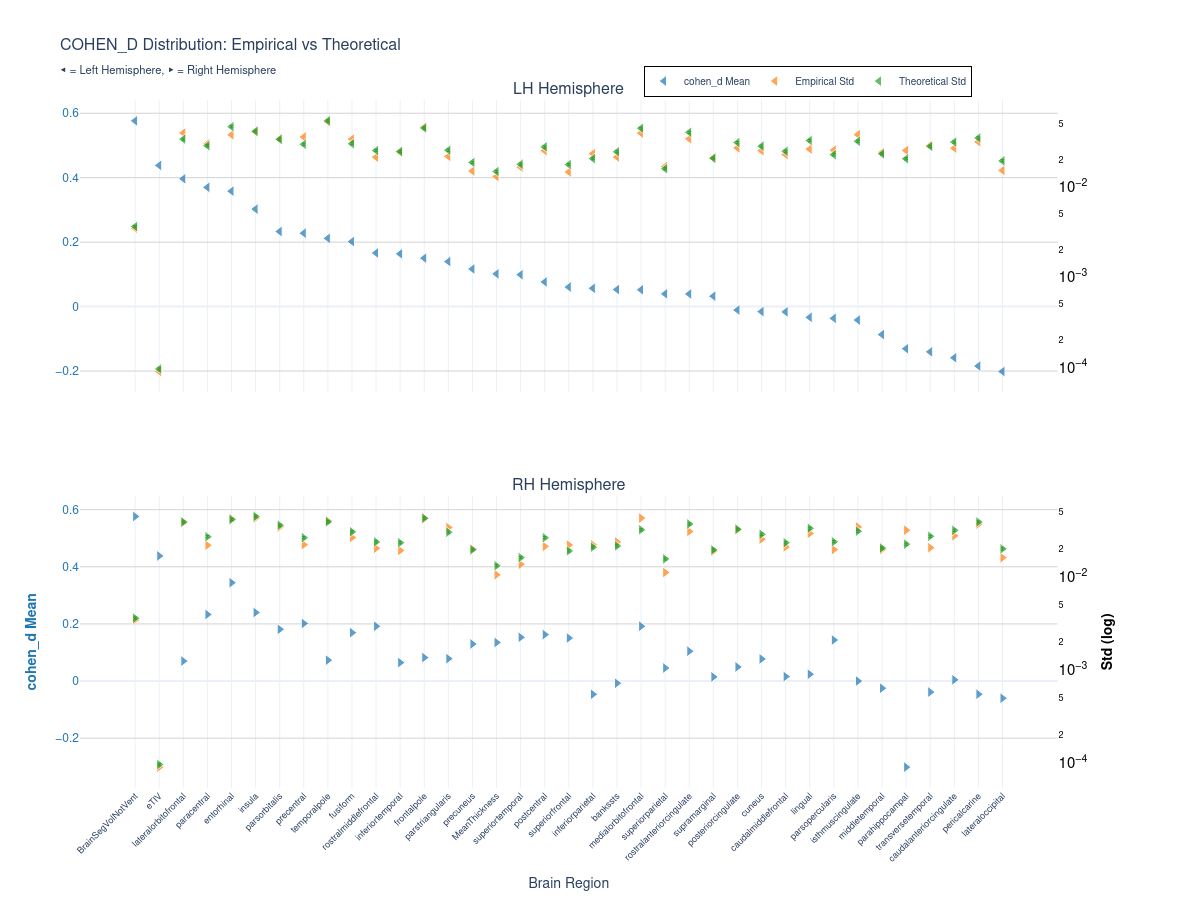

Saved difference plots to: <living-park>/numerical_validation/figures/baseline/thickness/difference_plots_cohen_d.png


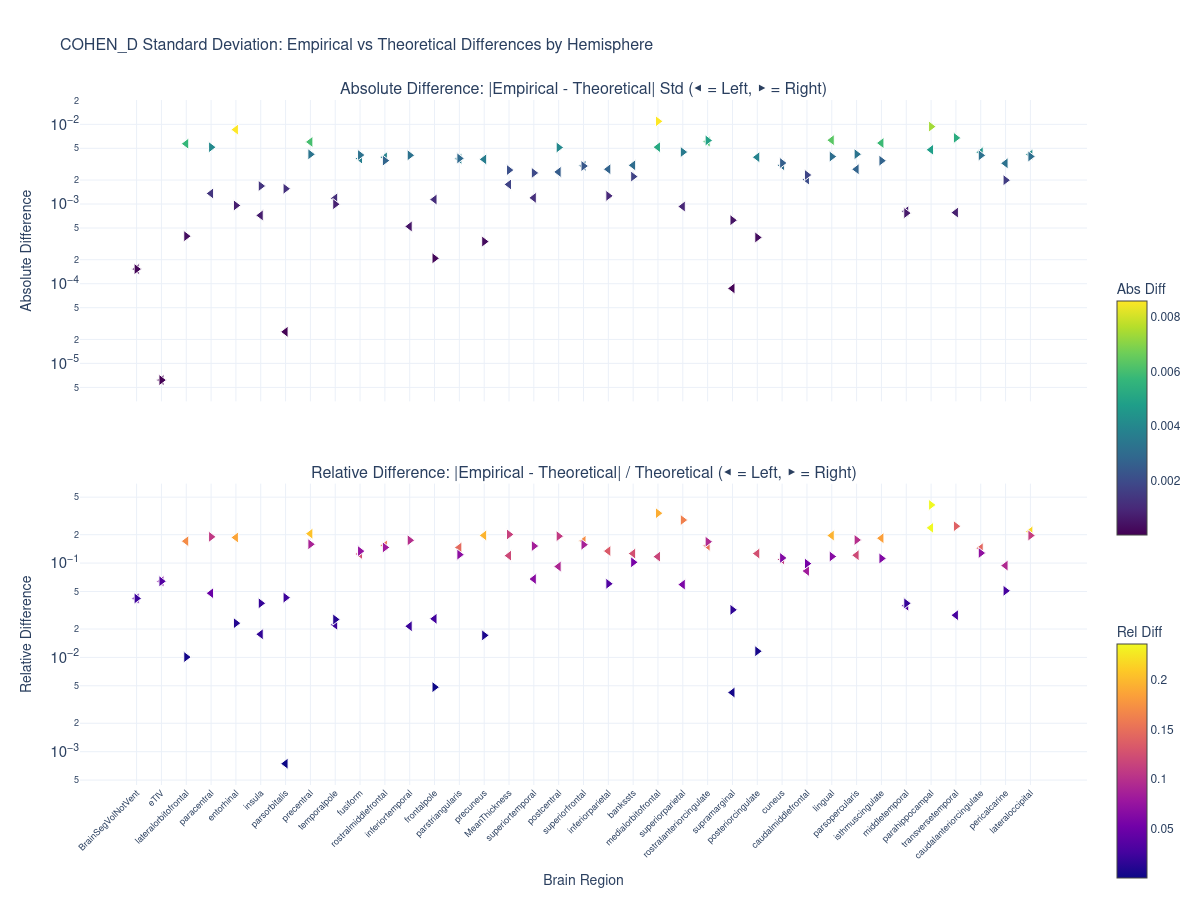

SUMMARY: Empirical vs Theoretical cohen_d Comparison

Absolute Differences (cohen_d_std_diff):
  Mean:   0.0030
  Median: 0.0030
  Min:    0.0000
  Max:    0.0109

Relative Differences (cohen_d_std_diff_rel):
  Mean:   11.66%
  Median: 11.87%
  Min:    0.07%
  Max:    41.38%

Top 5 Regions with Largest Relative Differences:
  parahippocampal (rh): 41.38% (cohen_d=-0.30)
  medialorbitofrontal (rh): 33.78% (cohen_d=0.19)
  superiorparietal (rh): 28.60% (cohen_d=0.05)
  transversetemporal (rh): 24.60% (cohen_d=-0.04)
  parahippocampal (lh): 23.63% (cohen_d=-0.13)


In [10]:
nu_nav = df_navr[(df_navr["timepoint"] == "baseline") & (df_navr["group"] == "HC-PD")]
data_path = stats_dir / f"cohen_d_baseline_{METRIC}.parquet"
df, stats = get_test_stats(
    data_path, stat_functions_F, nu_nav, hemisphere=True, study="baseline"
)
show_figure(
    stats, hemisphere=True, stat_name="cohen_d", study="baseline", metric=METRIC
)

### p-value

Saved Cohen's d stats to: <living-park>/numerical_validation/csv/baseline/thickness/cohen_d_stats_cohen_d.csv
Saved theoretical distributions to: <living-park>/numerical_validation/csv/baseline/thickness/theoretical_distributions_cohen_d.csv


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,timepoint,NAVR_CI_low,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high
0,BrainSegVolNotVent,lh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,baseline,0.024741,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716
1,BrainSegVolNotVent,rh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,baseline,0.024741,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716
2,MeanThickness,lh,0.101572,0.012923,0.074109,0.126129,0.102654,198.0,0.103311,0.008583,...,baseline,0.100497,0.106206,HC-PD,cross-sectional,thickness,194,0.014684,0.014284,0.015095
3,MeanThickness,rh,0.135026,0.010591,0.113855,0.151219,0.135628,198.0,0.093275,0.007752,...,baseline,0.090734,0.095888,HC-PD,cross-sectional,thickness,194,0.013257,0.012896,0.013629
4,bankssts,lh,0.052824,0.021218,0.022082,0.089911,0.049105,198.0,0.170819,0.022908,...,baseline,0.166165,0.175605,HC-PD,cross-sectional,thickness,194,0.024279,0.023618,0.024959


Saved empirical vs theoretical differences to: <living-park>/numerical_validation/csv/baseline/thickness/empirical_vs_theoretical_differences_cohen_d.csv
Cohen's d Theoretical vs Empirical Distribution Analysis
Sample size: 198
Degrees of freedom: 194
Number of regions: 74

Empirical vs Theoretical Comparison:
  Mean Cohen's d std relative diff: 11.657%


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high,cohen_d_std_diff,cohen_d_std_diff_rel
0,BrainSegVolNotVent,lh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716,0.000153,0.042204
1,BrainSegVolNotVent,rh,0.576278,0.003462,0.570603,0.582831,0.576250,198.0,0.025434,2748.433550,...,0.026147,HC-PD,cross-sectional,thickness,194,0.003615,0.003517,0.003716,0.000153,0.042204
2,MeanThickness,lh,0.101572,0.012923,0.074109,0.126129,0.102654,198.0,0.103311,0.008583,...,0.106206,HC-PD,cross-sectional,thickness,194,0.014684,0.014284,0.015095,0.001761,0.119945
3,MeanThickness,rh,0.135026,0.010591,0.113855,0.151219,0.135628,198.0,0.093275,0.007752,...,0.095888,HC-PD,cross-sectional,thickness,194,0.013257,0.012896,0.013629,0.002667,0.201156
4,bankssts,lh,0.052824,0.021218,0.022082,0.089911,0.049105,198.0,0.170819,0.022908,...,0.175605,HC-PD,cross-sectional,thickness,194,0.024279,0.023618,0.024959,0.003062,0.126100


Saved distribution uncertainty plot to: <living-park>/numerical_validation/figures/baseline/thickness/distribution_uncertainty_cohen_d.png


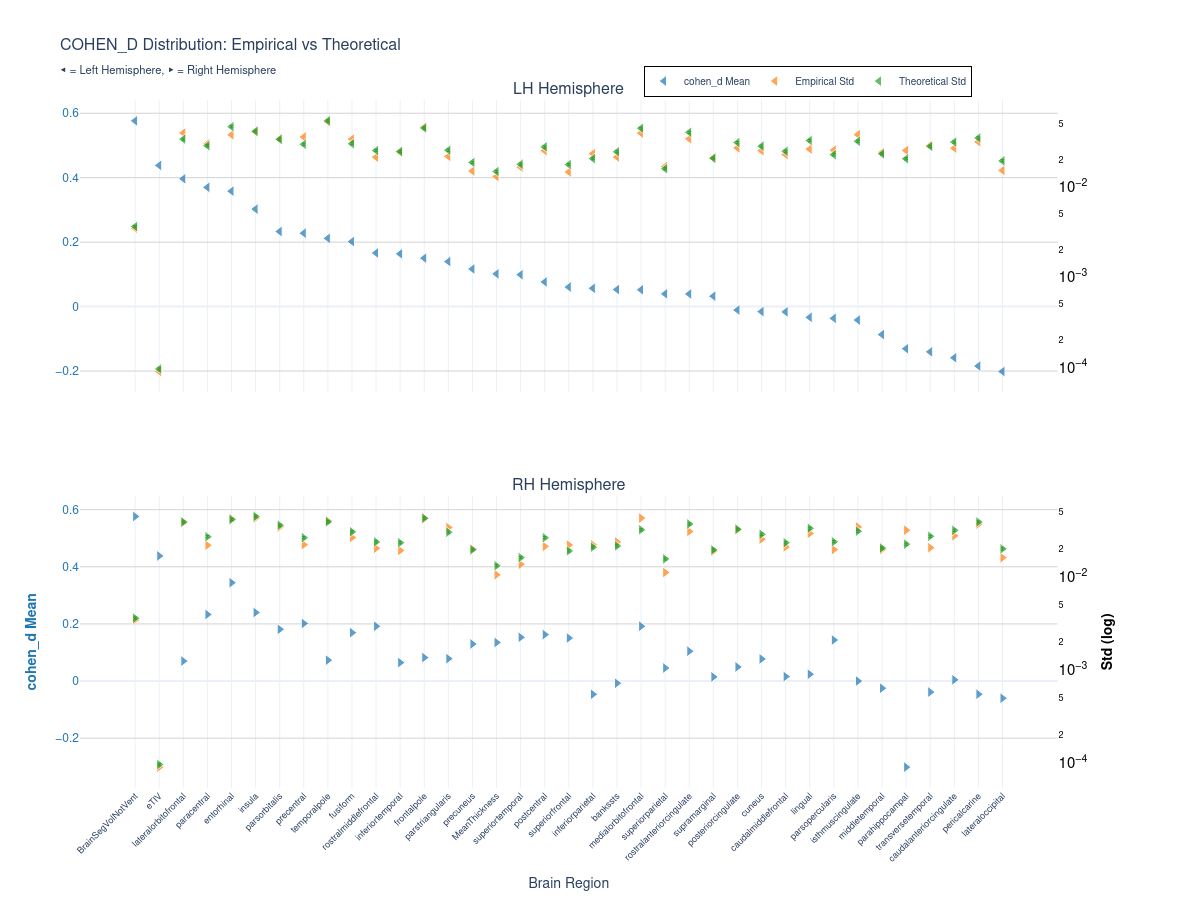

Saved difference plots to: <living-park>/numerical_validation/figures/baseline/thickness/difference_plots_cohen_d.png


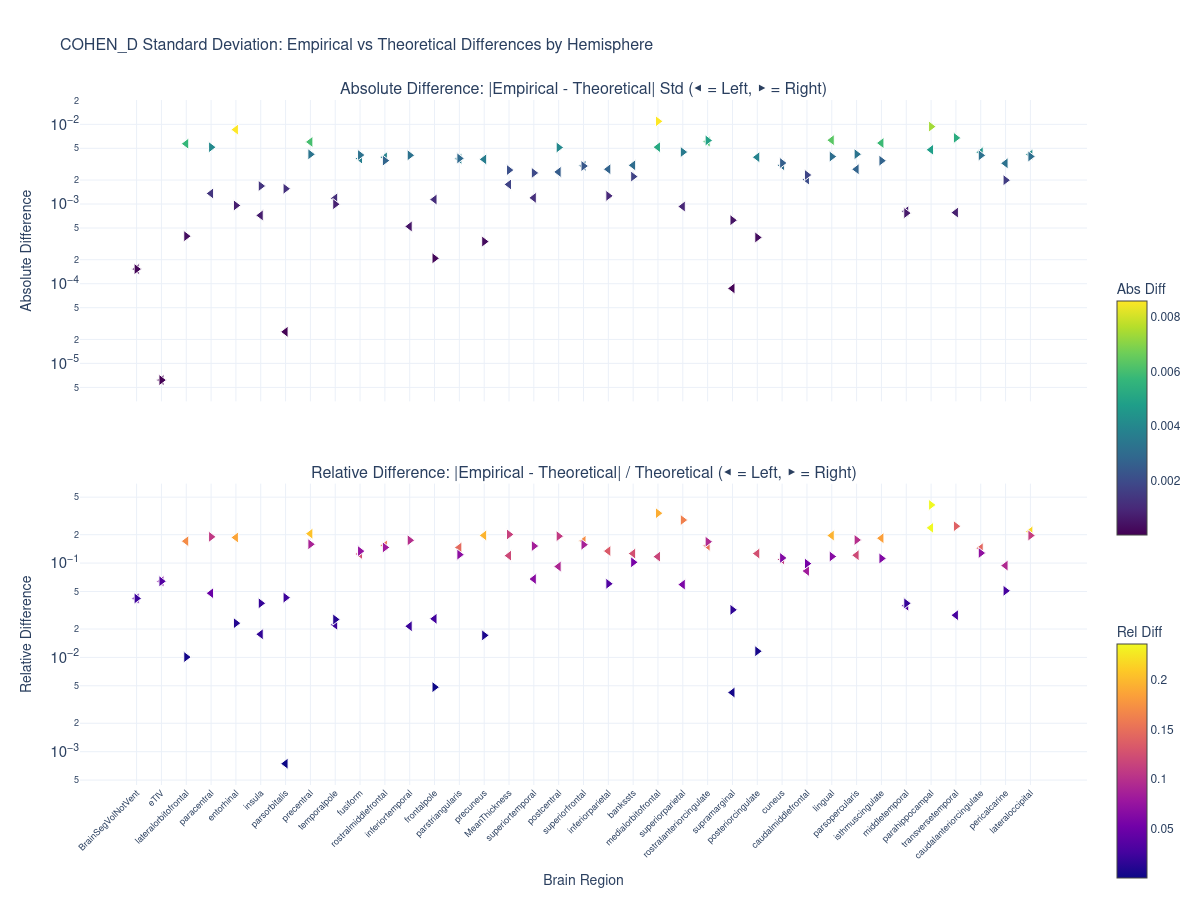

SUMMARY: Empirical vs Theoretical cohen_d Comparison

Absolute Differences (cohen_d_std_diff):
  Mean:   0.0030
  Median: 0.0030
  Min:    0.0000
  Max:    0.0109

Relative Differences (cohen_d_std_diff_rel):
  Mean:   11.66%
  Median: 11.87%
  Min:    0.07%
  Max:    41.38%

Top 5 Regions with Largest Relative Differences:
  parahippocampal (rh): 41.38% (cohen_d=-0.30)
  medialorbitofrontal (rh): 33.78% (cohen_d=0.19)
  superiorparietal (rh): 28.60% (cohen_d=0.05)
  transversetemporal (rh): 24.60% (cohen_d=-0.04)
  parahippocampal (lh): 23.63% (cohen_d=-0.13)


In [11]:
nu_nav = df_navr[(df_navr["timepoint"] == "baseline") & (df_navr["group"] == "HC-PD")]
data_path = stats_dir / f"cohen_d_baseline_{METRIC}.parquet"
df, stats = get_test_stats(
    data_path, stat_functions_F, nu_nav, hemisphere=True, study="baseline"
)
show_figure(
    stats, hemisphere=True, stat_name="cohen_d", study="baseline", metric=METRIC
)

![](../../numerical_validation/figures/baseline/distribution_uncertainty_p-val.png)
![](../../numerical_validation/figures/baseline/difference_plots_p-val.png)

## Longitudinal

### Cohen's d

Saved Cohen's d stats to: <living-park>/numerical_validation/csv/longitudinal/thickness/cohen_d_stats_cohen_d.csv
Saved theoretical distributions to: <living-park>/numerical_validation/csv/longitudinal/thickness/theoretical_distributions_cohen_d.csv


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,timepoint,NAVR_CI_low,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high
0,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
1,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
2,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
3,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
4,MeanThickness,lh,-0.036454,0.048071,-0.154338,0.033758,-0.025109,192.0,0.345627,0.005154,...,None,0.338896,0.352495,HC-PD,longitudinal,thickness,188,0.049887,0.048915,0.050878


Saved empirical vs theoretical differences to: <living-park>/numerical_validation/csv/longitudinal/thickness/empirical_vs_theoretical_differences_cohen_d.csv
Cohen's d Theoretical vs Empirical Distribution Analysis
Sample size: 192
Degrees of freedom: 188
Number of regions: 156

Empirical vs Theoretical Comparison:
  Mean Cohen's d std relative diff: 11.198%


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high,cohen_d_std_diff,cohen_d_std_diff_rel
0,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
1,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
2,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
3,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
4,MeanThickness,lh,-0.036454,0.048071,-0.154338,0.033758,-0.025109,192.0,0.345627,0.005154,...,0.352495,HC-PD,longitudinal,thickness,188,0.049887,0.048915,0.050878,0.001816,0.036392


Saved distribution uncertainty plot to: <living-park>/numerical_validation/figures/longitudinal/thickness/distribution_uncertainty_cohen_d.png


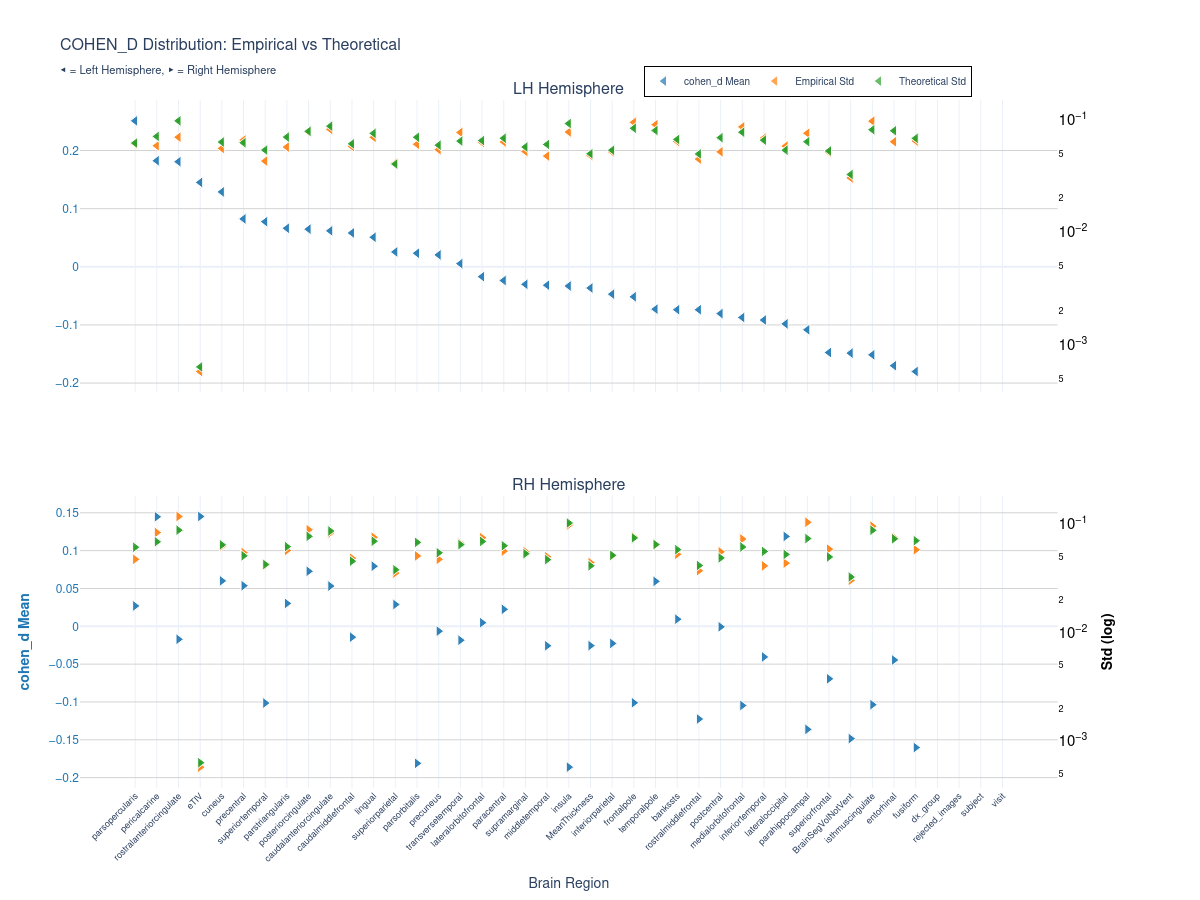

Saved difference plots to: <living-park>/numerical_validation/figures/longitudinal/thickness/difference_plots_cohen_d.png


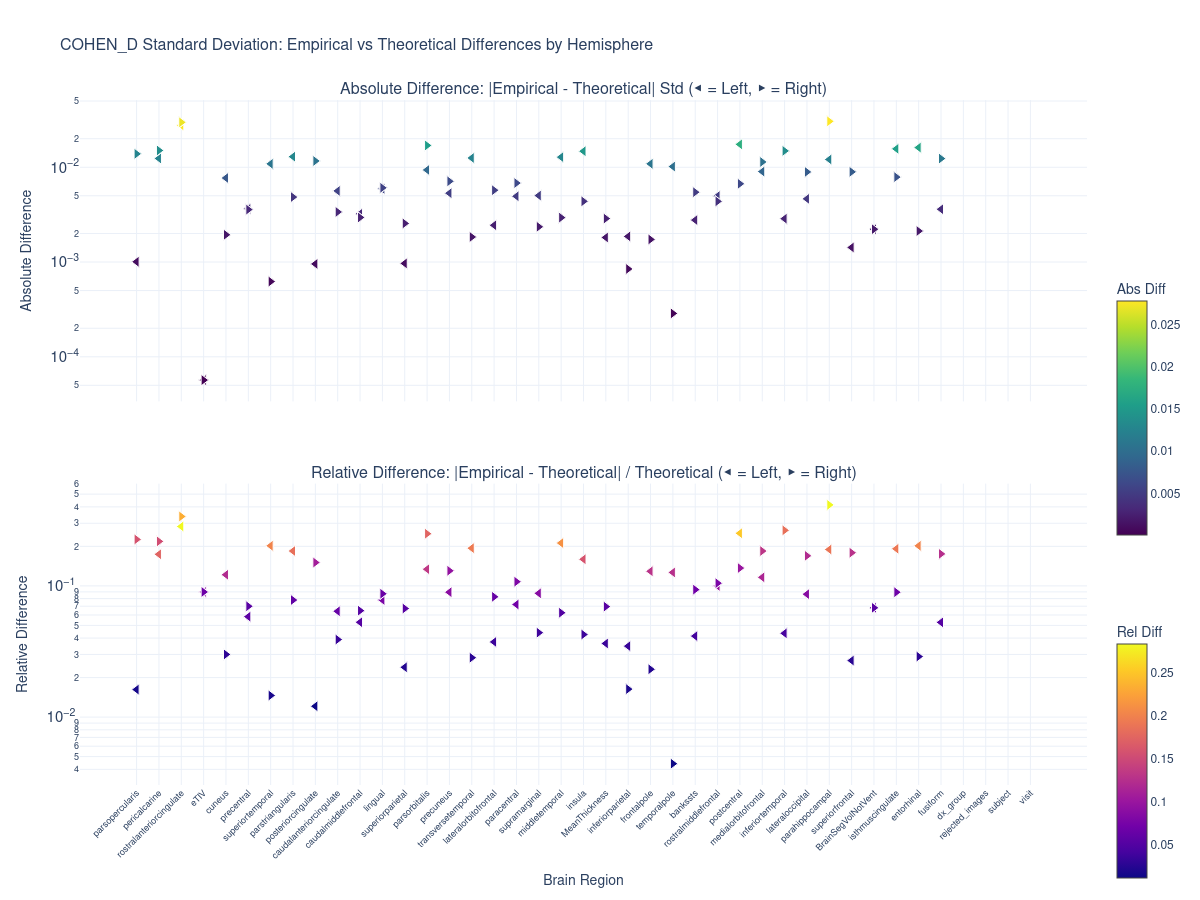

SUMMARY: Empirical vs Theoretical cohen_d Comparison

Absolute Differences (cohen_d_std_diff):
  Mean:   0.0073
  Median: 0.0052
  Min:    0.0001
  Max:    0.0305

Relative Differences (cohen_d_std_diff_rel):
  Mean:   11.20%
  Median: 8.86%
  Min:    0.44%
  Max:    41.39%

Top 5 Regions with Largest Relative Differences:
  parahippocampal (rh): 41.39% (cohen_d=-0.14)
  parahippocampal (rh): 41.39% (cohen_d=-0.14)
  rostralanteriorcingulate (rh): 33.80% (cohen_d=-0.02)
  rostralanteriorcingulate (rh): 33.80% (cohen_d=-0.02)
  rostralanteriorcingulate (lh): 28.36% (cohen_d=0.18)


In [12]:
nu_nav = df_navr[(df_navr["study"] == "longitudinal") & (df_navr["group"] == "HC-PD")]
data_path = stats_dir / f"cohen_d_longitudinal_{METRIC}.parquet"
df, stats = get_test_stats(
    data_path, stat_functions_F, nu_nav, hemisphere=True, study="longitudinal"
)
show_figure(
    stats, hemisphere=True, stat_name="cohen_d", study="longitudinal", metric=METRIC
)

![](https://raw.githubusercontent.com/yohanchatelain/livingpark-numerical-variability/main/freesurfer-fuzzy/numerical_validation/figures/longitudinal/distribution_uncertainty_F.png)

![](https://raw.githubusercontent.com/yohanchatelain/livingpark-numerical-variability/main/freesurfer-fuzzy/numerical_validation/figures/longitudinal/difference_plots_F.png)

### p-value

Saved Cohen's d stats to: <living-park>/numerical_validation/csv/longitudinal/thickness/cohen_d_stats_cohen_d.csv
Saved theoretical distributions to: <living-park>/numerical_validation/csv/longitudinal/thickness/theoretical_distributions_cohen_d.csv


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,timepoint,NAVR_CI_low,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high
0,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
1,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
2,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
3,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,None,0.221551,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261
4,MeanThickness,lh,-0.036454,0.048071,-0.154338,0.033758,-0.025109,192.0,0.345627,0.005154,...,None,0.338896,0.352495,HC-PD,longitudinal,thickness,188,0.049887,0.048915,0.050878


Saved empirical vs theoretical differences to: <living-park>/numerical_validation/csv/longitudinal/thickness/empirical_vs_theoretical_differences_cohen_d.csv
Cohen's d Theoretical vs Empirical Distribution Analysis
Sample size: 192
Degrees of freedom: 188
Number of regions: 156

Empirical vs Theoretical Comparison:
  Mean Cohen's d std relative diff: 11.198%


,region,hemisphere,cohen_d_mean,cohen_d_std,cohen_d_min,cohen_d_max,cohen_d_median,n_first,NAVR,num,...,NAVR_CI_high,group,study,metric,df_denominator,cohen_d_std_theoretical,cohen_d_std_theoretical_low,cohen_d_std_theoretical_high,cohen_d_std_diff,cohen_d_std_diff_rel
0,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
1,BrainSegVolNotVent,lh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
2,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
3,BrainSegVolNotVent,rh,-0.148449,0.030394,-0.223390,-0.084709,-0.148496,192.0,0.225951,0.003516,...,0.230441,HC-PD,longitudinal,thickness,188,0.032613,0.031978,0.033261,0.002219,0.068053
4,MeanThickness,lh,-0.036454,0.048071,-0.154338,0.033758,-0.025109,192.0,0.345627,0.005154,...,0.352495,HC-PD,longitudinal,thickness,188,0.049887,0.048915,0.050878,0.001816,0.036392


Saved distribution uncertainty plot to: <living-park>/numerical_validation/figures/longitudinal/thickness/distribution_uncertainty_cohen_d.png


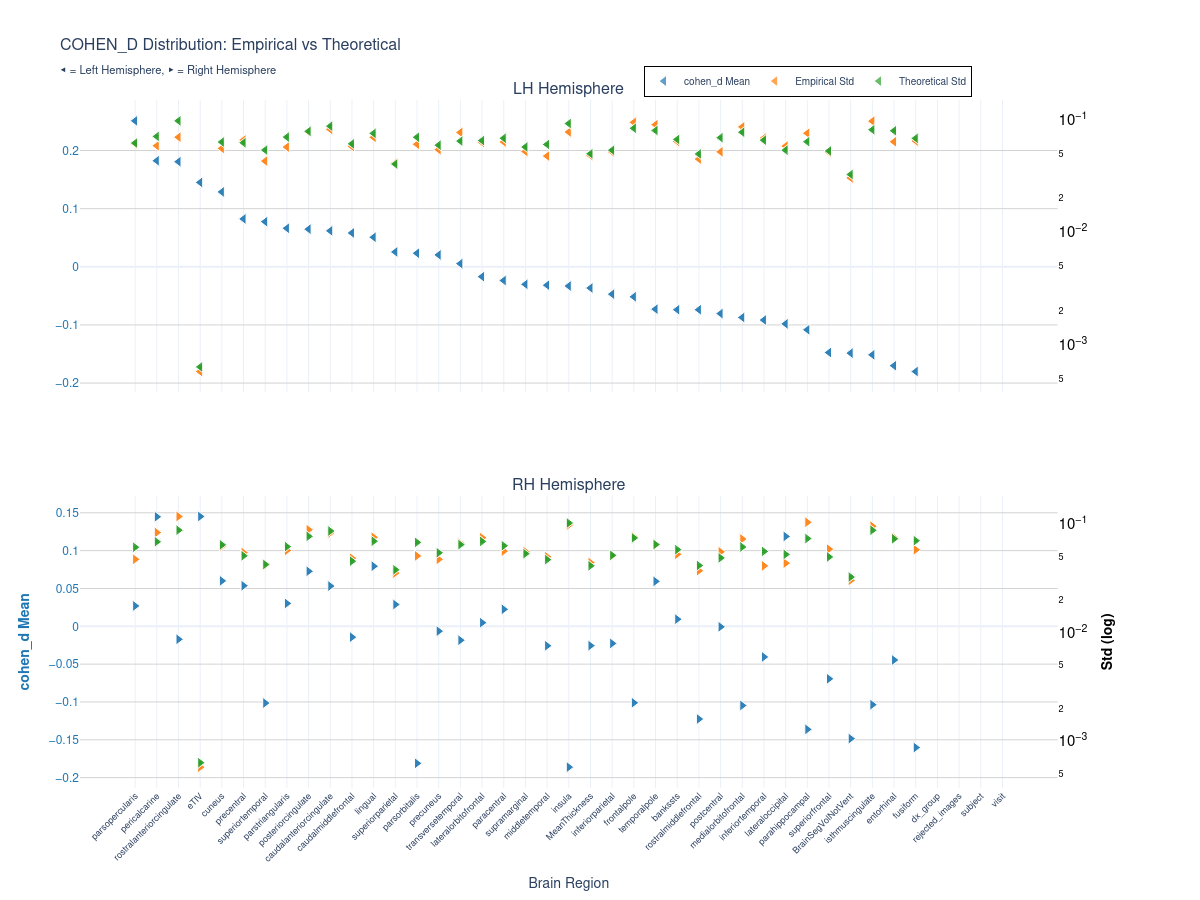

Saved difference plots to: <living-park>/numerical_validation/figures/longitudinal/thickness/difference_plots_cohen_d.png


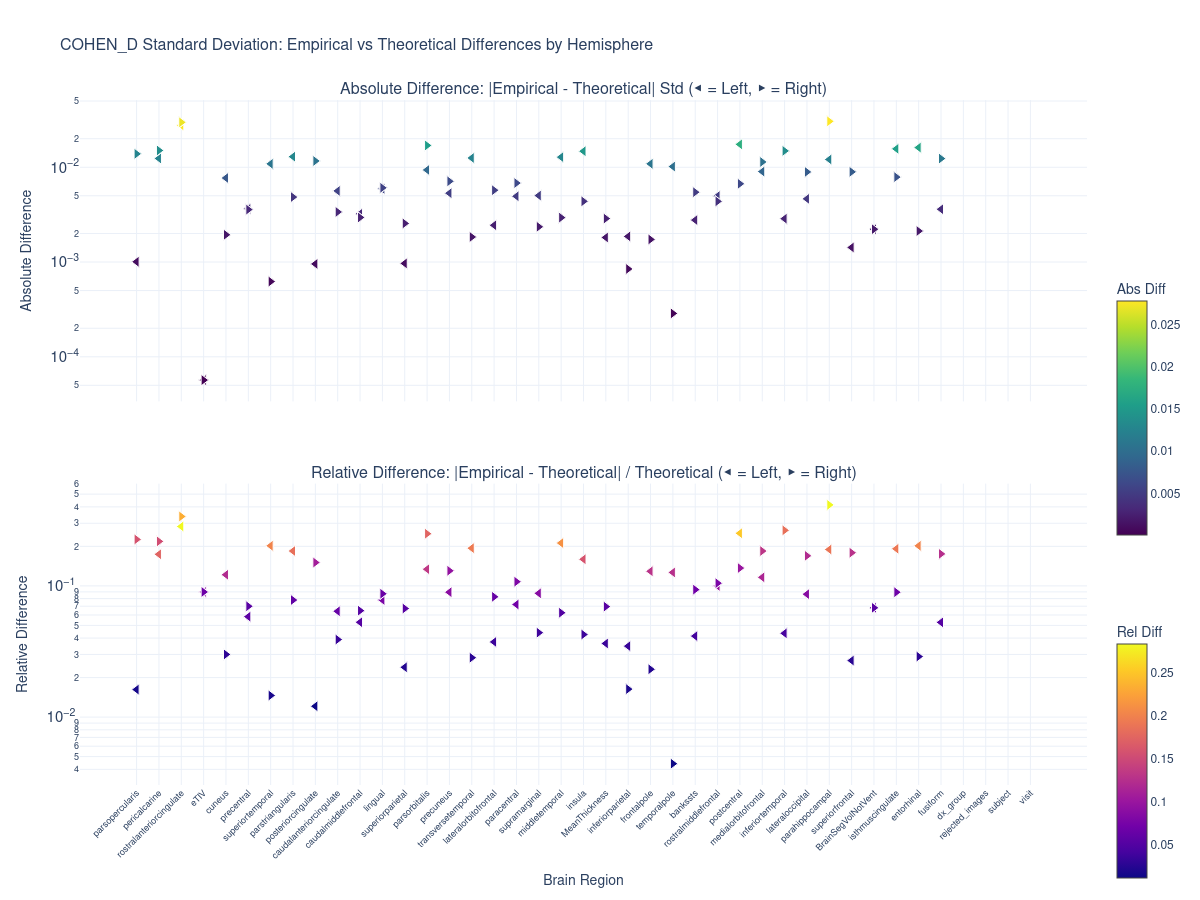

SUMMARY: Empirical vs Theoretical cohen_d Comparison

Absolute Differences (cohen_d_std_diff):
  Mean:   0.0073
  Median: 0.0052
  Min:    0.0001
  Max:    0.0305

Relative Differences (cohen_d_std_diff_rel):
  Mean:   11.20%
  Median: 8.86%
  Min:    0.44%
  Max:    41.39%

Top 5 Regions with Largest Relative Differences:
  parahippocampal (rh): 41.39% (cohen_d=-0.14)
  parahippocampal (rh): 41.39% (cohen_d=-0.14)
  rostralanteriorcingulate (rh): 33.80% (cohen_d=-0.02)
  rostralanteriorcingulate (rh): 33.80% (cohen_d=-0.02)
  rostralanteriorcingulate (lh): 28.36% (cohen_d=0.18)


In [13]:
nu_nav = df_navr[(df_navr["study"] == "longitudinal") & (df_navr["group"] == "HC-PD")]
data_path = stats_dir / f"cohen_d_longitudinal_{METRIC}.parquet"
df, stats = get_test_stats(
    data_path, stat_functions_F, nu_nav, hemisphere=True, study="longitudinal"
)
show_figure(
    stats, hemisphere=True, stat_name="cohen_d", study="longitudinal", metric=METRIC
)

![](../../numerical_validation/figures/longitudinal/distribution_uncertainty_p-val.png)
![](../../numerical_validation/figures/longitudinal/difference_plots_p-val.png)

![](../../navr/numerical_validation/figures/longitudinal/distribution_uncertainty_p-val.png)
![](../../navr/numerical_validation/figures/longitudinal/difference_plots_p-val.png)

![](../../navr/numerical_validation/figures/longitudinal/distribution_uncertainty_p-val.png)
![](../../navr/numerical_validation/figures/longitudinal/difference_plots_p-val.png)